C:\Users\athee\AppData\Local\Temp\ipykernel_1556\4228244656.py:172: RuntimeWarning: divide by zero encountered in scalar divide
  psnr_mobius_watermark = 10 * np.log10((255**2) / mse_mobius_watermark)


SSIM (Original Watermark vs. Extracted Watermark): 1.0000
PSNR (Original Watermark vs. Extracted Watermark): inf
MSE (Original Watermark vs. Extracted Watermark): 0.0000
BER (Original Watermark vs. Extracted Watermark): 0.0000
NCC (Original Watermark vs. Extracted Watermark): 1.0000
SSIM (Original Image vs. Watermarked Image): 0.9840
PSNR (Original Image vs. Watermarked Image): 52.7737
MSE (Original Image vs. Watermarked Image): 0.3433


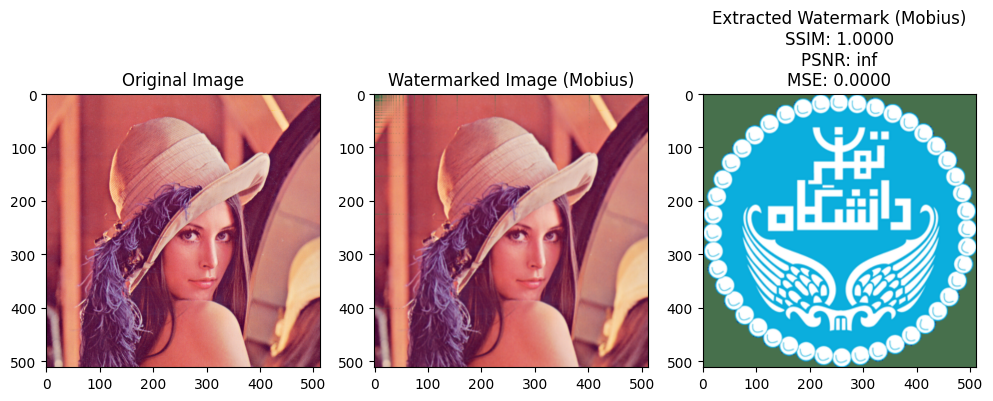

Extracted Watermark (Size 1) saved at: extracted_watermark_haar_level_1_logo1.png


C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\metrics\_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
C:\Users\athee\AppData\Local\Temp\ipykernel_1556\4228244656.py:172: RuntimeWarning: divide by zero encountered in scalar divide
  psnr_mobius_watermark = 10 *

SSIM (Original Watermark vs. Extracted Watermark): 1.0000
PSNR (Original Watermark vs. Extracted Watermark): inf
MSE (Original Watermark vs. Extracted Watermark): 0.0000
BER (Original Watermark vs. Extracted Watermark): 0.0000
NCC (Original Watermark vs. Extracted Watermark): 1.0000
SSIM (Original Image vs. Watermarked Image): 0.9967
PSNR (Original Image vs. Watermarked Image): 51.2161
MSE (Original Image vs. Watermarked Image): 0.4914


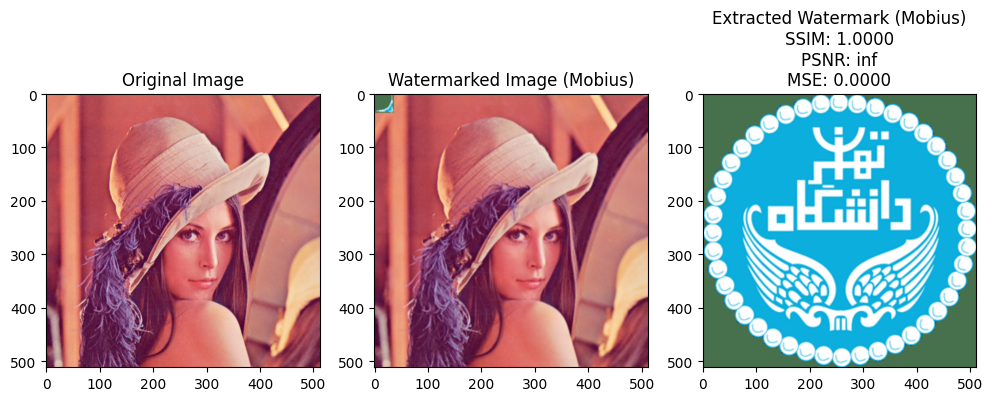

Extracted Watermark (Size 2) saved at: extracted_watermark_haar_level_2_logo1.png


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import pywt
from deap import base, creator, tools, algorithms
import os

# Define Mobius transform function
def mobius_transform(x, y, a, b, c, d):
    new_x = (a * x + b) / (c * x + d)
    new_y = (a * y + b) / (c * y + d)
    return new_x, new_y

# Define inverse Mobius transform function
def inverse_mobius_transform(new_x, new_y, a, b, c, d):
    x = (d * new_x - b) / (a - c * new_x)
    y = (d * new_y - b) / (a - c * new_y)
    return x, y

# Define a function to embed watermark in DWT coefficients using Mobius Transform
def embed_watermark_dwt_mobius(original_image, watermark, alpha, mobius_params, wavelet='haar', level=1):
    coeffs = pywt.dwt2(original_image, wavelet)
    LL, (LH, HL, HH) = coeffs

    watermark_gray = cv2.cvtColor(watermark, cv2.COLOR_BGR2GRAY)
    watermark_resized = cv2.resize(watermark_gray, (LL.shape[1], LL.shape[0]))

    watermarked_LL = np.copy(LL)

    height, width = watermark_resized.shape[:2]

    a, b, c, d = mobius_params

    print("Shape of watermarked_LL:", watermarked_LL.shape)
    print("Shape of watermark_resized:", watermark_resized.shape)

    for y in range(height):
        for x in range(width):
            new_x, new_y = mobius_transform(x, y, a, b, c, d)
            if 0 <= new_x < width and 0 <= new_y < height:
                print("new_x:", new_x, "new_y:", new_y)
                print("Expected shape for addition:", watermarked_LL[int(new_y), int(new_x)].shape)
                print("Shape of alpha * watermark_resized[y, x]:", (alpha * watermark_resized[y, x]).shape)
                watermarked_LL[int(new_y), int(new_x)] += alpha * watermark_resized[y, x]

    watermarked_coeffs = (watermarked_LL, (LH, HL, HH))
    watermarked_image = pywt.idwt2(watermarked_coeffs, wavelet)

    watermarked_image = np.clip(watermarked_image, 0, 255).astype(np.uint8)

    return watermarked_image


# Define a function to extract watermark from DWT coefficients using Mobius Transform
def extract_watermark_dwt_mobius(watermarked_image, original_image, alpha, mobius_params, wavelet='haar', level=1):
    coeffs_watermarked = pywt.dwt2(watermarked_image, wavelet)
    LL_watermarked, (_, _, _) = coeffs_watermarked

    coeffs_original = pywt.dwt2(original_image, wavelet)
    LL_original, (_, _, _) = coeffs_original

    extracted_watermark = np.zeros_like(LL_original)

    height, width = extracted_watermark.shape[:2]

    a, b, c, d = mobius_params

    for y in range(height):
        for x in range(width):
            new_x, new_y = mobius_transform(x, y, a, b, c, d)
            if 0 <= new_x < width and 0 <= new_y < height:
                extracted_watermark[y, x] = (LL_watermarked[int(new_y), int(new_x)] - LL_original[y, x]) / alpha

    return extracted_watermark

# Define a function to calculate Bit Error Rate (BER)
def calculate_ber(original_watermark, extracted_watermark):
    num_errors = np.sum(original_watermark != extracted_watermark)
    total_bits = original_watermark.size
    ber = num_errors / total_bits
    return ber

# Define a function to calculate Normalized Cross-Correlation (NCC)
def calculate_ncc(original_watermark, extracted_watermark):
    original_watermark = (original_watermark - np.mean(original_watermark)) / np.std(original_watermark)
    extracted_watermark = (extracted_watermark - np.mean(extracted_watermark)) / np.std(extracted_watermark)
    ncc = np.sum(original_watermark * extracted_watermark) / original_watermark.size
    return ncc

# Define a function to optimize Mobius transform parameters using Genetic algorithm
def optimize_mobius_parameters_DEAP(original_image, watermark_image):
    height, width = watermark_image.shape[:2]

    def fitness(params):
        a, b, c, d = params
        extracted_watermark = np.zeros_like(watermark_image)

        for y in range(height):
            for x in range(width):
                new_x, new_y = mobius_transform(x, y, a, b, c, d)
                if 0 <= new_x < width and 0 <= new_y < height:
                    extracted_watermark[int(new_y), int(new_x)] = watermark_image[y, x]

        ssim_value = ssim(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark, cv2.COLOR_BGR2GRAY), data_range=extracted_watermark.max() - extracted_watermark.min())
        return ssim_value,

    creator.create("FitnessMin", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, -10.0, 10.0)
    toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_float,), n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", fitness)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1.0, indpb=0.2)
    toolbox.register("select", tools.selBest)

    population_size = 50
    generations = 20
    population = toolbox.population(n=population_size)

    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    for gen in range(generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for ind, fit in zip(offspring, fits):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=population_size)

    best_ind = tools.selBest(population, k=1)[0]
    return best_ind

# Function to process an image with watermark using Mobius Transform
def process_image_mobius(input_image_path, watermark_image_path, mobius_params, wavelet='haar', level=1, fake_disappear=False):
    original_image = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    watermark_image = cv2.imread(watermark_image_path, cv2.IMREAD_COLOR)

    if watermark_image is None:
        raise Exception(f"Failed to load watermark image from '{watermark_image_path}'")

    watermark_image = cv2.resize(watermark_image, (original_image.shape[1], original_image.shape[0]))

    watermarked_image_mobius = np.copy(original_image)

    if mobius_params is not None:
        a, b, c, d = mobius_params

        for y in range(original_image.shape[0]):
            for x in range(original_image.shape[1]):
                new_x, new_y = mobius_transform(x, y, a, b, c, d)
                if 0 <= new_x < original_image.shape[1] and 0 <= new_y < original_image.shape[0]:
                    watermarked_image_mobius[int(new_y), int(new_x)] = watermark_image[y, x]

    extracted_watermark_mobius = np.zeros_like(watermark_image)

    for y in range(original_image.shape[0]):
        for x in range(original_image.shape[1]):
            new_x, new_y = inverse_mobius_transform(x, y, 1.0, 0.0, 0.0, 1.0)

            if 0 <= new_x < original_image.shape[1] and 0 <= new_y < original_image.shape[0]:
                extracted_watermark_mobius[y, x] = watermark_image[int(new_y), int(new_x)]

    ssim_mobius = ssim(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY), data_range=extracted_watermark_mobius.max() - extracted_watermark_mobius.min())
    mse_mobius_watermark = mean_squared_error(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))
    psnr_mobius_watermark = 10 * np.log10((255**2) / mse_mobius_watermark)

    ssim_image = ssim(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY), data_range=watermarked_image_mobius.max() - watermarked_image_mobius.min())
    mse_mobius_image = mean_squared_error(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY))
    psnr_mobius_image = 10 * np.log10((255**2) / mse_mobius_image)

    ber_mobius_watermark = calculate_ber(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))
    ncc_mobius_watermark = calculate_ncc(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))

    print(f"SSIM (Original Watermark vs. Extracted Watermark): {ssim_mobius:.4f}")
    print(f"PSNR (Original Watermark vs. Extracted Watermark): {psnr_mobius_watermark:.4f}")
    print(f"MSE (Original Watermark vs. Extracted Watermark): {mse_mobius_watermark:.4f}")
    print(f"BER (Original Watermark vs. Extracted Watermark): {ber_mobius_watermark:.4f}")
    print(f"NCC (Original Watermark vs. Extracted Watermark): {ncc_mobius_watermark:.4f}")

    print(f"SSIM (Original Image vs. Watermarked Image): {ssim_image:.4f}")
    print(f"PSNR (Original Image vs. Watermarked Image): {psnr_mobius_image:.4f}")
    print(f"MSE (Original Image vs. Watermarked Image): {mse_mobius_image:.4f}")
    kernel_size = (3, 3)
    watermarked_image_mobius = cv2.GaussianBlur(watermarked_image_mobius, kernel_size, 0)

    plt.figure(figsize=(12, 6))
    plt.subplot(131), plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
    plt.subplot(132), plt.imshow(cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2RGB)), plt.title('Watermarked Image (Mobius)')
    plt.subplot(133), plt.imshow(cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2RGB)), plt.title(f'Extracted Watermark (Mobius)\nSSIM: {ssim_mobius:.4f}\nPSNR: {psnr_mobius_watermark:.4f}\nMSE: {mse_mobius_watermark:.4f}')
    plt.show()
    if fake_disappear:
        alpha = 0.3
        watermarked_image_mobius = cv2.addWeighted(watermarked_image_mobius, alpha, original_image, 1 - alpha, 0)

    watermark_name = os.path.basename(watermark_image_path)
    extracted_watermark_path = f"extracted_watermark_{wavelet}_level_{level}_{watermark_name}"
    cv2.imwrite(extracted_watermark_path, extracted_watermark_mobius)

    return extracted_watermark_path

# Load the medical image
image_path = 'lena.png'
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if original_image is None:
    raise Exception(f"Failed to load image from '{image_path}'")

# Define the paths to the watermarks of two different sizes
watermark_path_1 = 'logo1.png'

desired_size_original = (256, 256)
resized_original_image = cv2.resize(original_image, desired_size_original)

desired_size_watermark_1 = (32, 32)
resized_watermark_1 = cv2.resize(cv2.imread(watermark_path_1), desired_size_watermark_1)

desired_size_watermark_2 = (256, 256)
resized_watermark_2 = cv2.resize(cv2.imread(watermark_path_1), desired_size_watermark_2)

optimized_params_1 = optimize_mobius_parameters_DEAP(resized_original_image, resized_watermark_1)

if optimized_params_1 is not None:
    extracted_watermark_path_1 = process_image_mobius(image_path, watermark_path_1, optimized_params_1, wavelet='haar', level=1, fake_disappear=True)
    print(f"Extracted Watermark (Size 1) saved at: {extracted_watermark_path_1}")
else:
    print("Optimization for Watermark (Size 1) did not converge to a solution.")

optimized_params_2 = optimize_mobius_parameters_DEAP(resized_original_image, resized_watermark_2)

if optimized_params_2 is not None:
    extracted_watermark_path_2 = process_image_mobius(image_path, watermark_path_1, optimized_params_2, wavelet='haar', level=2, fake_disappear=True)
    print(f"Extracted Watermark (Size 2) saved at: {extracted_watermark_path_2}")
else:
    print("Optimization for Watermark (Size 2) did not converge to a solution.")


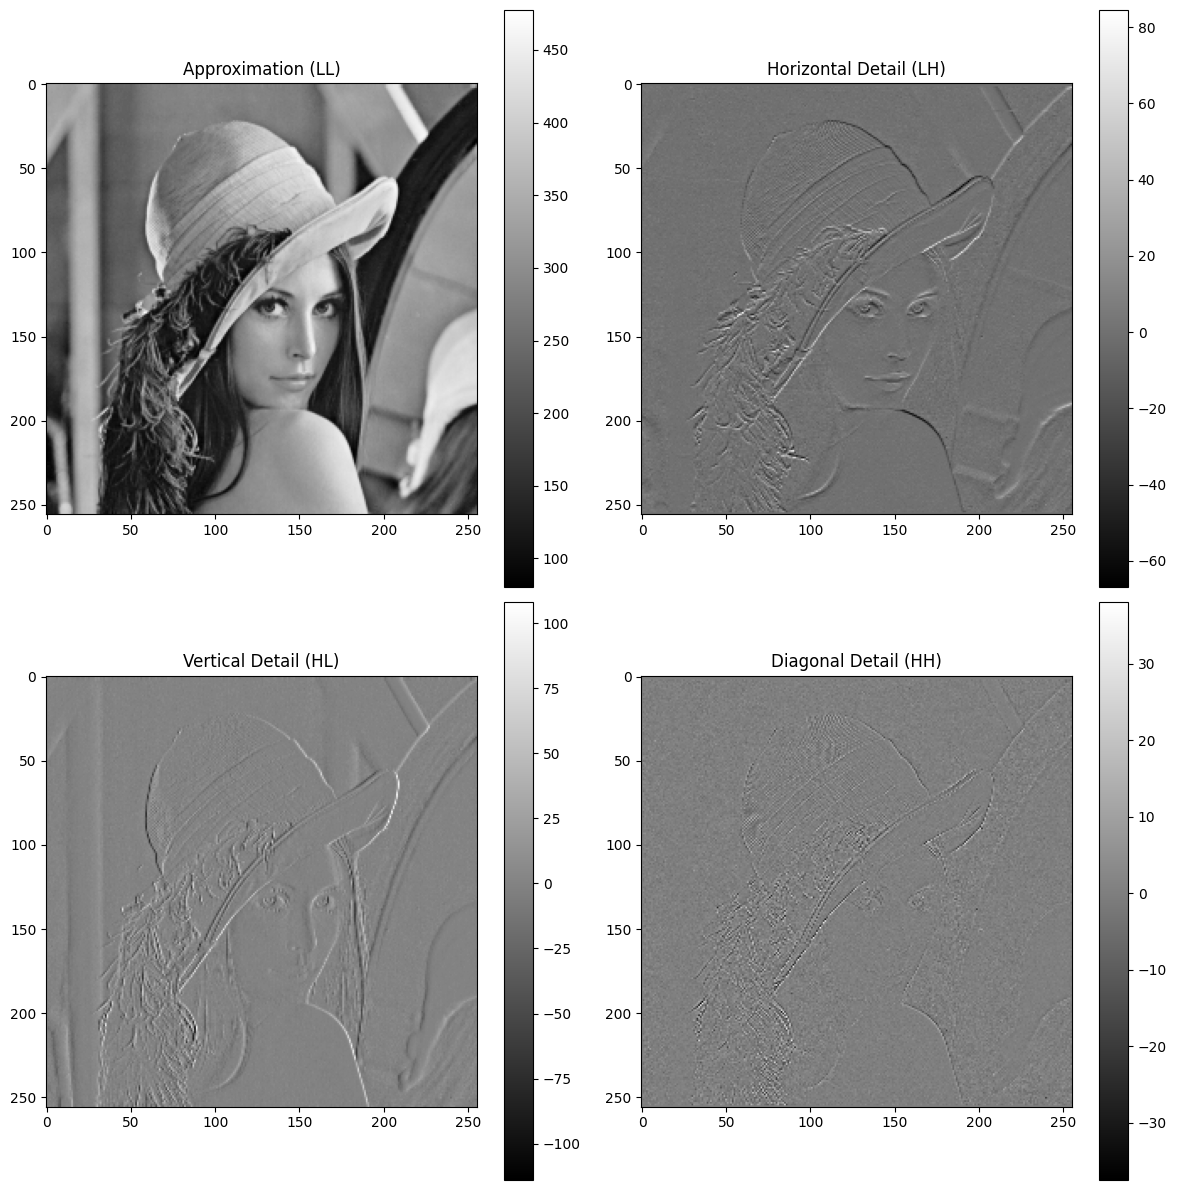

In [10]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Load the image
image_path = 'lena.png'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Perform Haar DWT decomposition
coeffs = pywt.dwt2(original_image, 'haar')
LL, (LH, HL, HH) = coeffs

# Plot the decomposed components
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.imshow(LL, cmap='gray')
plt.title('Approximation (LL)')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(LH, cmap='gray')
plt.title('Horizontal Detail (LH)')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(HL, cmap='gray')
plt.title('Vertical Detail (HL)')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(HH, cmap='gray')
plt.title('Diagonal Detail (HH)')
plt.colorbar()

plt.tight_layout()
plt.show()


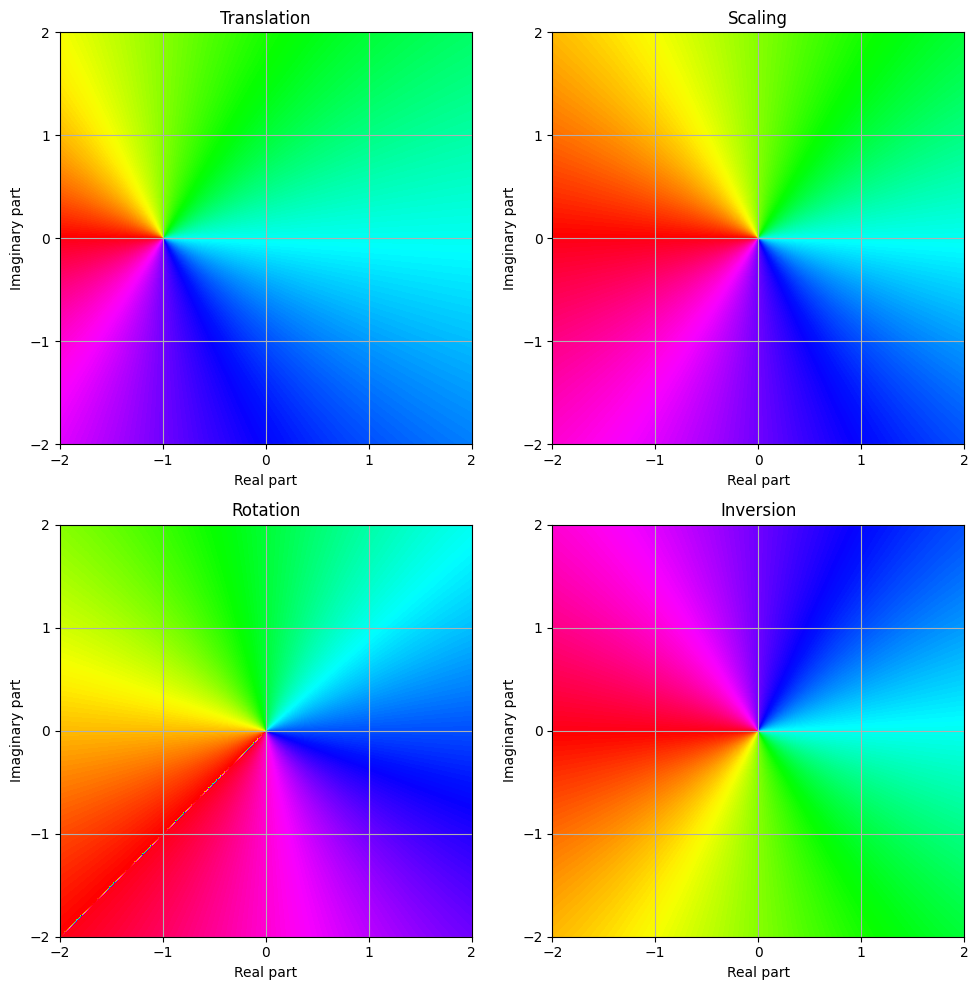

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Möbius transformation function
def mobius_transform(z, a, b, c, d):
    return (a * z + b) / (c * z + d)

# Define a grid of complex numbers for visualization
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Special case: Translation
a, b, c, d = 1, 1, 0, 1
translated = mobius_transform(Z, a, b, c, d)

# Special case: Scaling
a, b, c, d = 2, 0, 0, 1
scaled = mobius_transform(Z, a, b, c, d)

# Special case: Rotation
theta = np.pi / 4  # 45 degree rotation
a, b, c, d = np.exp(1j * theta), 0, 0, 1
rotated = mobius_transform(Z, a, b, c, d)

# Special case: Inversion
a, b, c, d = 0, 1, 1, 0
inverted = mobius_transform(Z, a, b, c, d)

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(np.angle(translated), extent=(-2, 2, -2, 2), cmap='hsv')
axes[0, 0].set_title('Translation')

axes[0, 1].imshow(np.angle(scaled), extent=(-2, 2, -2, 2), cmap='hsv')
axes[0, 1].set_title('Scaling')

axes[1, 0].imshow(np.angle(rotated), extent=(-2, 2, -2, 2), cmap='hsv')
axes[1, 0].set_title('Rotation')

axes[1, 1].imshow(np.angle(inverted), extent=(-2, 2, -2, 2), cmap='hsv')
axes[1, 1].set_title('Inversion')

for ax in axes.flat:
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    ax.set_xticks(np.arange(-2, 3, 1))
    ax.set_yticks(np.arange(-2, 3, 1))
    ax.grid(True)

plt.tight_layout()
plt.show()


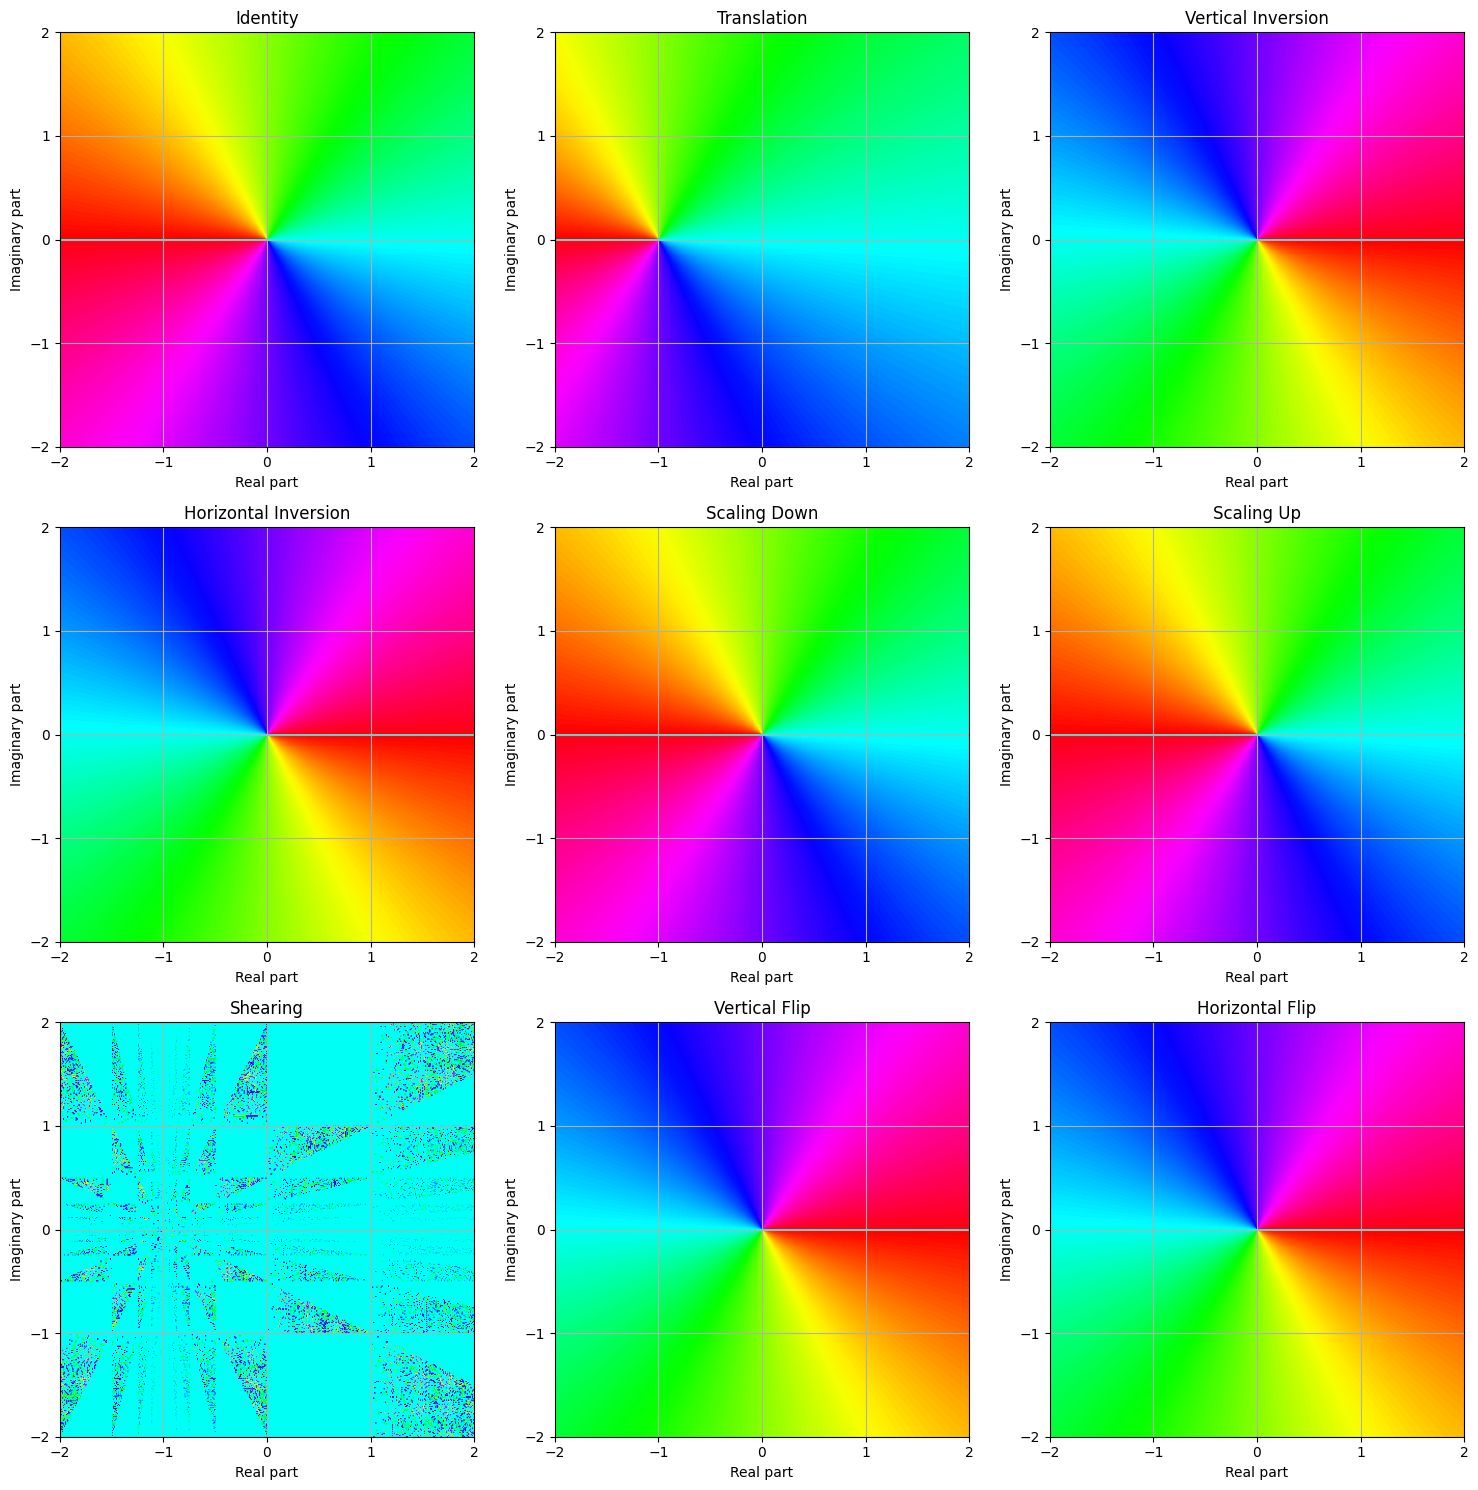

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Möbius transformation function
def mobius_transform(z, a, b, c, d):
    return (a * z + b) / (c * z + d)

# Define a grid of complex numbers for visualization
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Special cases of Möbius transformations
transforms = {
    "Identity": (1, 0, 0, 1),
    "Translation": (1, 1, 0, 1),
    "Vertical Inversion": (1, 0, 0, -1),
    "Horizontal Inversion": (-1, 0, 0, 1),
    "Scaling Down": (0.5, 0, 0, 1),
    "Scaling Up": (2, 0, 0, 1),
    "Shearing": (1, 1, 1, 1),
    "Vertical Flip": (1, 0, 0, -1),
    "Horizontal Flip": (-1, 0, 0, 1)
}

# Plot the results
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for ax, (title, params) in zip(axes.flat, transforms.items()):
    a, b, c, d = params
    transformed = mobius_transform(Z, a, b, c, d)
    ax.imshow(np.angle(transformed), extent=(-2, 2, -2, 2), cmap='hsv')
    ax.set_title(title)
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    ax.set_xticks(np.arange(-2, 3, 1))
    ax.set_yticks(np.arange(-2, 3, 1))
    ax.grid(True)

plt.tight_layout()
plt.show()


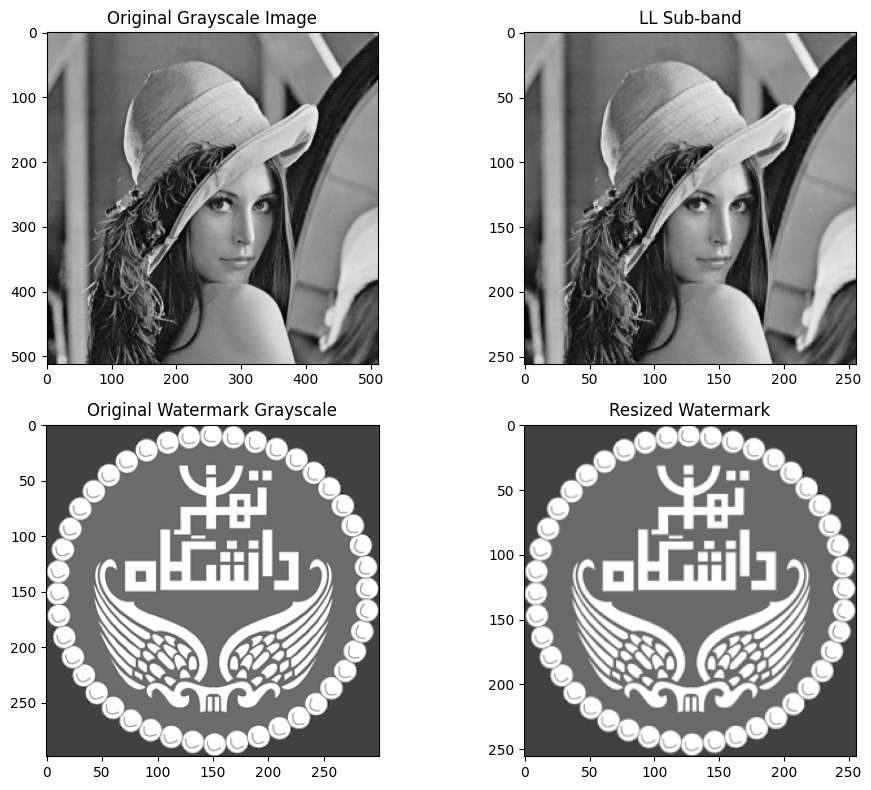

In [2]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Load the original image
image_path = 'lena.png'
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if original_image is None:
    raise Exception(f"Failed to load image from '{image_path}'")

# Convert the original image to grayscale
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Apply DWT to the original image
coeffs = pywt.dwt2(gray_image, 'haar')
LL, (LH, HL, HH) = coeffs

# Load the watermark image
watermark_path = 'logo1.png'
watermark_image = cv2.imread(watermark_path, cv2.IMREAD_COLOR)

if watermark_image is None:
    raise Exception(f"Failed to load watermark image from '{watermark_path}'")

# Convert the watermark image to grayscale
watermark_gray = cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY)

# Resize the watermark image to match the dimensions of the LL sub-band
watermark_resized = cv2.resize(watermark_gray, (LL.shape[1], LL.shape[0]))

# Display the original grayscale image, LL sub-band, original watermark, and resized watermark
plt.figure(figsize=(10, 8))

plt.subplot(221), plt.imshow(gray_image, cmap='gray'), plt.title('Original Grayscale Image')
plt.subplot(222), plt.imshow(LL, cmap='gray'), plt.title('LL Sub-band')
plt.subplot(223), plt.imshow(watermark_gray, cmap='gray'), plt.title('Original Watermark Grayscale')
plt.subplot(224), plt.imshow(watermark_resized, cmap='gray'), plt.title('Resized Watermark')

plt.tight_layout()
plt.show()


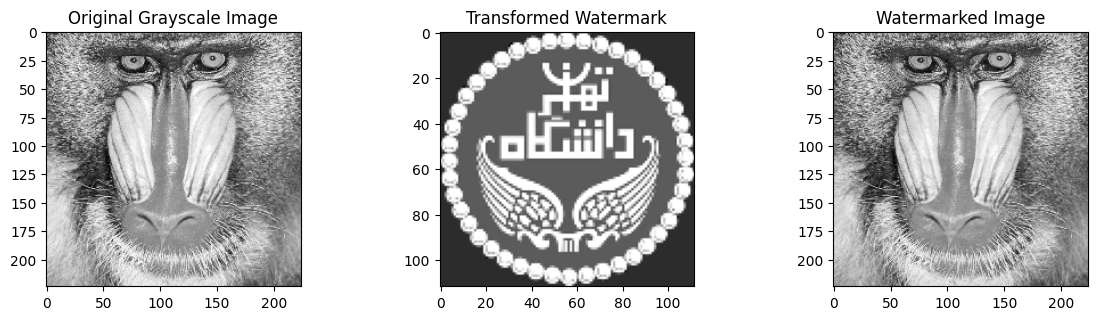

In [3]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Define the Möbius transform function
def mobius_transform(x, y, a, b, c, d):
    new_x = (a * x + b) / (c * x + d)
    new_y = (a * y + b) / (c * y + d)
    return new_x, new_y

# Load the original image
image_path = 'mandril_color.tif'
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if original_image is None:
    raise Exception(f"Failed to load image from '{image_path}'")

# Convert the original image to grayscale
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Apply DWT to the original image
coeffs = pywt.dwt2(gray_image, 'haar')
LL, (LH, HL, HH) = coeffs

# Load the watermark image
watermark_path = 'logo1.png'
watermark_image = cv2.imread(watermark_path, cv2.IMREAD_COLOR)

if watermark_image is None:
    raise Exception(f"Failed to load watermark image from '{watermark_path}'")

# Convert the watermark image to grayscale
watermark_gray = cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY)

# Resize the watermark image to match the dimensions of the LL sub-band
watermark_resized = cv2.resize(watermark_gray, (LL.shape[1], LL.shape[0]))

# Apply the Möbius transform to the watermark coordinates
a, b, c, d = 1, 0, 0, 1  # Example parameters for the Möbius transform

# Create a blank watermark image to store the transformed watermark
transformed_watermark = np.zeros_like(watermark_resized)

height, width = watermark_resized.shape

for y in range(height):
    for x in range(width):
        new_x, new_y = mobius_transform(x, y, a, b, c, d)
        new_x = int(new_x) % width  # Ensure new coordinates are within image bounds
        new_y = int(new_y) % height
        transformed_watermark[new_y, new_x] = watermark_resized[y, x]

# Embed the transformed watermark into the LL sub-band
alpha = 0.1  # Watermark embedding strength
watermarked_LL = LL + alpha * transformed_watermark

# Reconstruct the watermarked image using the modified LL sub-band
watermarked_coeffs = (watermarked_LL, (LH, HL, HH))
watermarked_image = pywt.idwt2(watermarked_coeffs, 'haar')

# Clip the values to ensure they fall within the valid range [0, 255]
watermarked_image = np.clip(watermarked_image, 0, 255).astype(np.uint8)

# Display the original grayscale image, transformed watermark, and watermarked image
plt.figure(figsize=(12, 6))

plt.subplot(231), plt.imshow(gray_image, cmap='gray'), plt.title('Original Grayscale Image')
plt.subplot(232), plt.imshow(transformed_watermark, cmap='gray'), plt.title('Transformed Watermark')
plt.subplot(233), plt.imshow(watermarked_image, cmap='gray'), plt.title('Watermarked Image')

plt.tight_layout()
plt.show()


C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\metrics\_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
C:\Users\athee\AppData\Local\Temp\ipykernel_15080\1826918394.py:180: RuntimeWarning: divide by zero encountered in scalar divide
  psnr_mobius_watermark = 10 

SSIM (Original Watermark vs. Extracted Watermark): 1.0000
PSNR (Original Watermark vs. Extracted Watermark): inf
MSE (Original Watermark vs. Extracted Watermark): 0.0000
BER (Original Watermark vs. Extracted Watermark): 0.0000
NCC (Original Watermark vs. Extracted Watermark): 1.0000
SSIM (Original Image vs. Watermarked Image): 0.9955
PSNR (Original Image vs. Watermarked Image): 52.0741
MSE (Original Image vs. Watermarked Image): 0.4033
Chi-Square Distance: 0.027403351087690354
Correlation: 0.9971357455532831
Intersection: 12.580089222559764
Bhattacharyya Distance: 0.019197102891884487


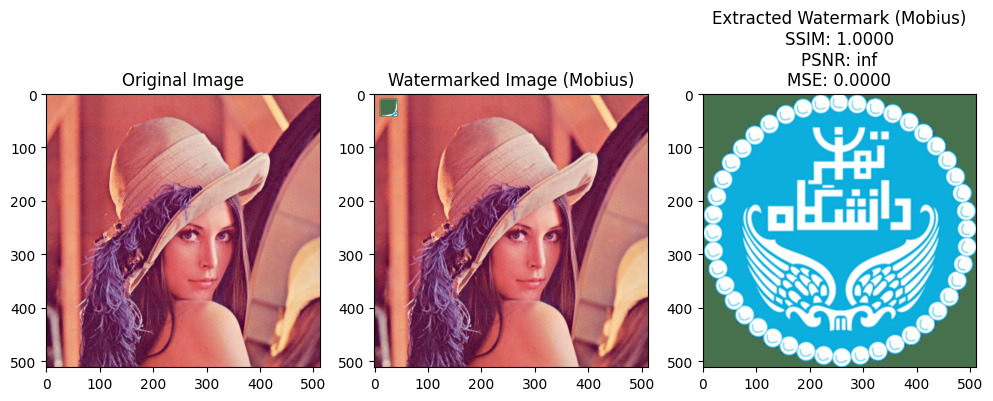

Extracted Watermark (Size 1) saved at: extracted_watermark_haar_level_1_logo1.png


C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\metrics\_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
C:\Users\athee\AppData\Local\Temp\ipykernel_15080\1826918394.py:180: RuntimeWarning: divide by zero encountered in scalar divide
  psnr_mobius_watermark = 10 

SSIM (Original Watermark vs. Extracted Watermark): 1.0000
PSNR (Original Watermark vs. Extracted Watermark): inf
MSE (Original Watermark vs. Extracted Watermark): 0.0000
BER (Original Watermark vs. Extracted Watermark): 0.0000
NCC (Original Watermark vs. Extracted Watermark): 1.0000
SSIM (Original Image vs. Watermarked Image): 1.0000
PSNR (Original Image vs. Watermarked Image): inf
MSE (Original Image vs. Watermarked Image): 0.0000
Chi-Square Distance: 0.0
Correlation: 1.0
Intersection: 12.633123375046125
Bhattacharyya Distance: 0.0


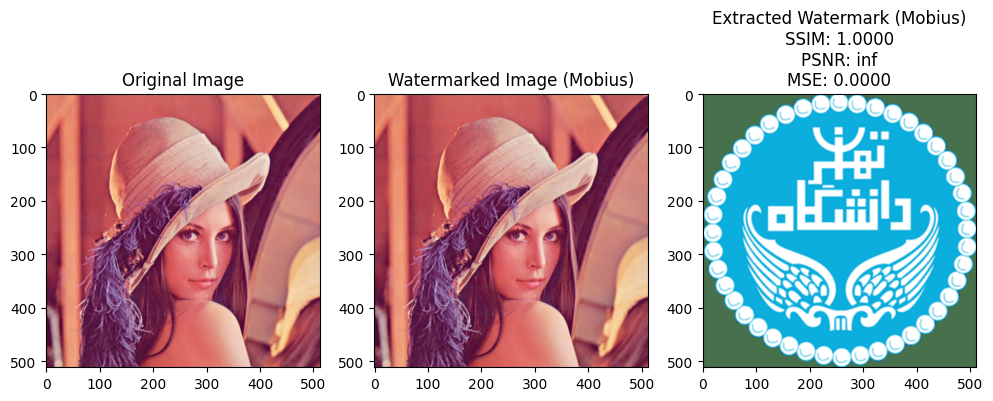

Extracted Watermark (Size 2) saved at: extracted_watermark_haar_level_2_logo1.png


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import pywt
from deap import base, creator, tools, algorithms
import os

# Define Mobius transform function
def mobius_transform(x, y, a, b, c, d):
    new_x = (a * x + b) / (c * x + d)
    new_y = (a * y + b) / (c * y + d)
    return new_x, new_y

# Define inverse Mobius transform function
def inverse_mobius_transform(new_x, new_y, a, b, c, d):
    x = (d * new_x - b) / (a - c * new_x)
    y = (d * new_y - b) / (a - c * new_y)
    return x, y

# Define a function to embed watermark in DWT coefficients using Mobius Transform
def embed_watermark_dwt_mobius(original_image, watermark, alpha, mobius_params, wavelet='haar', level=1):
    coeffs = pywt.dwt2(original_image, wavelet)
    LL, (LH, HL, HH) = coeffs

    watermark_gray = cv2.cvtColor(watermark, cv2.COLOR_BGR2GRAY)
    watermark_resized = cv2.resize(watermark_gray, (LL.shape[1], LL.shape[0]))

    watermarked_LL = np.copy(LL)

    height, width = watermark_resized.shape[:2]

    a, b, c, d = mobius_params

    for y in range(height):
        for x in range(width):
            new_x, new_y = mobius_transform(x, y, a, b, c, d)
            if 0 <= new_x < width and 0 <= new_y < height:
                watermarked_LL[int(new_y), int(new_x)] += alpha * watermark_resized[y, x]

    watermarked_coeffs = (watermarked_LL, (LH, HL, HH))
    watermarked_image = pywt.idwt2(watermarked_coeffs, wavelet)

    watermarked_image = np.clip(watermarked_image, 0, 255).astype(np.uint8)

    return watermarked_image

# Define a function to extract watermark from DWT coefficients using Mobius Transform
def extract_watermark_dwt_mobius(watermarked_image, original_image, alpha, mobius_params, wavelet='haar', level=1):
    coeffs_watermarked = pywt.dwt2(watermarked_image, wavelet)
    LL_watermarked, (_, _, _) = coeffs_watermarked

    coeffs_original = pywt.dwt2(original_image, wavelet)
    LL_original, (_, _, _) = coeffs_original

    extracted_watermark = np.zeros_like(LL_original)

    height, width = extracted_watermark.shape[:2]

    a, b, c, d = mobius_params

    for y in range(height):
        for x in range(width):
            new_x, new_y = mobius_transform(x, y, a, b, c, d)
            if 0 <= new_x < width and 0 <= new_y < height:
                extracted_watermark[y, x] = (LL_watermarked[int(new_y), int(new_x)] - LL_original[y, x]) / alpha

    return extracted_watermark

# Define a function to calculate Bit Error Rate (BER)
def calculate_ber(original_watermark, extracted_watermark):
    num_errors = np.sum(original_watermark != extracted_watermark)
    total_bits = original_watermark.size
    ber = num_errors / total_bits
    return ber

# Define a function to calculate Normalized Cross-Correlation (NCC)
def calculate_ncc(original_watermark, extracted_watermark):
    original_watermark = (original_watermark - np.mean(original_watermark)) / np.std(original_watermark)
    extracted_watermark = (extracted_watermark - np.mean(extracted_watermark)) / np.std(extracted_watermark)
    ncc = np.sum(original_watermark * extracted_watermark) / original_watermark.size
    return ncc

# Define a function to optimize Mobius transform parameters using Genetic algorithm
def optimize_mobius_parameters_DEAP(original_image, watermark_image):
    height, width = watermark_image.shape[:2]

    def fitness(params):
        a, b, c, d = params
        extracted_watermark = np.zeros_like(watermark_image)

        for y in range(height):
            for x in range(width):
                new_x, new_y = mobius_transform(x, y, a, b, c, d)
                if 0 <= new_x < width and 0 <= new_y < height:
                    extracted_watermark[int(new_y), int(new_x)] = watermark_image[y, x]

        ssim_value = ssim(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark, cv2.COLOR_BGR2GRAY), data_range=extracted_watermark.max() - extracted_watermark.min())
        return ssim_value,

    creator.create("FitnessMin", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, -10.0, 10.0)
    toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_float,), n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", fitness)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1.0, indpb=0.2)
    toolbox.register("select", tools.selBest)

    population_size = 50
    generations = 20
    population = toolbox.population(n=population_size)

    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    for gen in range(generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for ind, fit in zip(offspring, fits):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=population_size)

    best_ind = tools.selBest(population, k=1)[0]
    return best_ind

# Function to compare histograms
def compare_histograms(image1, image2):
    hist1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0, 256])

    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()

    chi_square = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    correlation = cv2.compareHist(hist1,hist2, cv2.HISTCMP_CORREL)
    intersection = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)
    bhattacharyya = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

    return chi_square, correlation, intersection, bhattacharyya

# Function to process an image with watermark using Mobius Transform
def process_image_mobius(input_image_path, watermark_image_path, mobius_params, wavelet='haar', level=1, fake_disappear=False):
    original_image = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    watermark_image = cv2.imread(watermark_image_path, cv2.IMREAD_COLOR)

    if watermark_image is None:
        raise Exception(f"Failed to load watermark image from '{watermark_image_path}'")

    watermark_image = cv2.resize(watermark_image, (original_image.shape[1], original_image.shape[0]))

    watermarked_image_mobius = np.copy(original_image)

    if mobius_params is not None:
        a, b, c, d = mobius_params

        for y in range(original_image.shape[0]):
            for x in range(original_image.shape[1]):
                new_x, new_y = mobius_transform(x, y, a, b, c, d)
                if 0 <= new_x < original_image.shape[1] and 0 <= new_y < original_image.shape[0]:
                    watermarked_image_mobius[int(new_y), int(new_x)] = watermark_image[y, x]

    extracted_watermark_mobius = np.zeros_like(watermark_image)

    for y in range(original_image.shape[0]):
        for x in range(original_image.shape[1]):
            new_x, new_y = inverse_mobius_transform(x, y, 1.0, 0.0, 0.0, 1.0)

            if 0 <= new_x < original_image.shape[1] and 0 <= new_y < original_image.shape[0]:
                extracted_watermark_mobius[y, x] = watermark_image[int(new_y), int(new_x)]

    ssim_mobius = ssim(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY), data_range=extracted_watermark_mobius.max() - extracted_watermark_mobius.min())
    mse_mobius_watermark = mean_squared_error(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))
    psnr_mobius_watermark = 10 * np.log10((255**2) / mse_mobius_watermark)

    ssim_image = ssim(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY), data_range=watermarked_image_mobius.max() - watermarked_image_mobius.min())
    mse_mobius_image = mean_squared_error(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY))
    psnr_mobius_image = 10 * np.log10((255**2) / mse_mobius_image)

    ber_mobius_watermark = calculate_ber(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))
    ncc_mobius_watermark = calculate_ncc(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))

    chi_square, correlation, intersection, bhattacharyya = compare_histograms(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY))

    print(f"SSIM (Original Watermark vs. Extracted Watermark): {ssim_mobius:.4f}")
    print(f"PSNR (Original Watermark vs. Extracted Watermark): {psnr_mobius_watermark:.4f}")
    print(f"MSE (Original Watermark vs. Extracted Watermark): {mse_mobius_watermark:.4f}")
    print(f"BER (Original Watermark vs. Extracted Watermark): {ber_mobius_watermark:.4f}")
    print(f"NCC (Original Watermark vs. Extracted Watermark): {ncc_mobius_watermark:.4f}")

    print(f"SSIM (Original Image vs. Watermarked Image): {ssim_image:.4f}")
    print(f"PSNR (Original Image vs. Watermarked Image): {psnr_mobius_image:.4f}")
    print(f"MSE (Original Image vs. Watermarked Image): {mse_mobius_image:.4f}")
    print(f"Chi-Square Distance: {chi_square}")
    print(f"Correlation: {correlation}")
    print(f"Intersection: {intersection}")
    print(f"Bhattacharyya Distance: {bhattacharyya}")

    plt.figure(figsize=(12, 6))
    plt.subplot(131), plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
    plt.subplot(132), plt.imshow(cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2RGB)), plt.title('Watermarked Image (Mobius)')
    plt.subplot(133), plt.imshow(cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2RGB)), plt.title(f'Extracted Watermark (Mobius)\nSSIM: {ssim_mobius:.4f}\nPSNR: {psnr_mobius_watermark:.4f}\nMSE: {mse_mobius_watermark:.4f}')
    plt.show()
    if fake_disappear:
        alpha = 0.3
        watermarked_image_mobius = cv2.addWeighted(watermarked_image_mobius, alpha, original_image, 1 - alpha, 0)

    watermark_name = os.path.basename(watermark_image_path)
    extracted_watermark_path = f"extracted_watermark_{wavelet}_level_{level}_{watermark_name}"
    cv2.imwrite(extracted_watermark_path, extracted_watermark_mobius)

    return extracted_watermark_path

# Load the medical image
image_path = 'lena.png'
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if original_image is None:
    raise Exception(f"Failed to load image from '{image_path}'")

# Define the paths to the watermarks of two different sizes
watermark_path_1 = 'logo1.png'

desired_size_original = (256, 256)
resizeddesired_size_original = (256, 256)
resized_original_image = cv2.resize(original_image, desired_size_original)

desired_size_watermark_1 = (32, 32)
resized_watermark_1 = cv2.resize(cv2.imread(watermark_path_1), desired_size_watermark_1)

desired_size_watermark_2 = (256, 256)
resized_watermark_2 = cv2.resize(cv2.imread(watermark_path_1), desired_size_watermark_2)

optimized_params_1 = optimize_mobius_parameters_DEAP(resized_original_image, resized_watermark_1)

if optimized_params_1 is not None:
    extracted_watermark_path_1 = process_image_mobius(image_path, watermark_path_1, optimized_params_1, wavelet='haar', level=1, fake_disappear=True)
    print(f"Extracted Watermark (Size 1) saved at: {extracted_watermark_path_1}")
else:
    print("Optimization for Watermark (Size 1) did not converge to a solution.")

optimized_params_2 = optimize_mobius_parameters_DEAP(resized_original_image, resized_watermark_2)

if optimized_params_2 is not None:
    extracted_watermark_path_2 = process_image_mobius(image_path, watermark_path_1, optimized_params_2, wavelet='haar', level=2, fake_disappear=True)
    print(f"Extracted Watermark (Size 2) saved at: {extracted_watermark_path_2}")
else:
    print("Optimization for Watermark (Size 2) did not converge to a solution.")




C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\metrics\_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
C:\Users\athee\AppData\Local\Temp\ipykernel_8972\536912691.py:180: RuntimeWarning: divide by zero encountered in scalar divide
  psnr_mobius_watermark = 10 * 

SSIM (Original Watermark vs. Extracted Watermark): 1.0000
PSNR (Original Watermark vs. Extracted Watermark): inf
MSE (Original Watermark vs. Extracted Watermark): 0.0000
BER (Original Watermark vs. Extracted Watermark): 0.0000
NCC (Original Watermark vs. Extracted Watermark): 1.0000
SSIM (Original Image vs. Watermarked Image): 0.9995
PSNR (Original Image vs. Watermarked Image): 62.6086
MSE (Original Image vs. Watermarked Image): 0.0357
Chi-Square Distance: 0.00013591200706691535
Correlation: 0.9999729453232022
Intersection: 13.240741543850163
Bhattacharyya Distance: 0.0011205625259016676


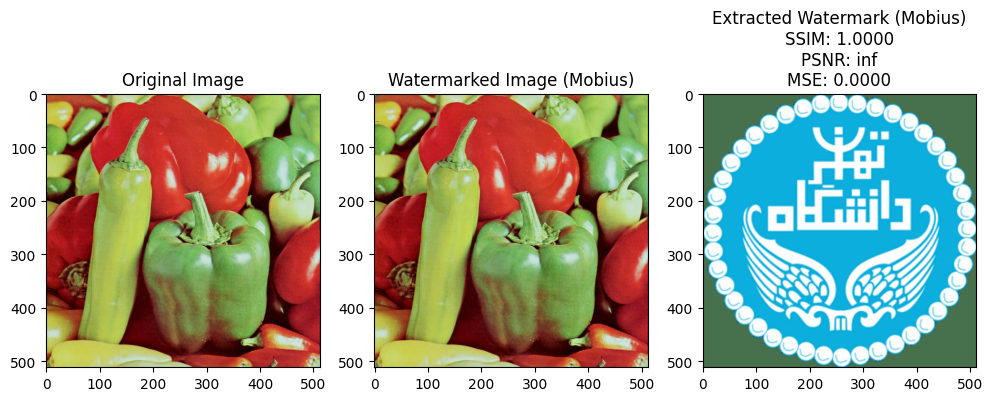

Extracted Watermark (Size 1) saved at: extracted_watermark_haar_level_1_logo1.png


C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\metrics\_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
C:\Users\athee\AppData\Local\Temp\ipykernel_8972\536912691.py:180: RuntimeWarning: divide by zero encountered in scalar divide
  psnr_mobius_watermark = 10 * 

SSIM (Original Watermark vs. Extracted Watermark): 1.0000
PSNR (Original Watermark vs. Extracted Watermark): inf
MSE (Original Watermark vs. Extracted Watermark): 0.0000
BER (Original Watermark vs. Extracted Watermark): 0.0000
NCC (Original Watermark vs. Extracted Watermark): 1.0000
SSIM (Original Image vs. Watermarked Image): 1.0000
PSNR (Original Image vs. Watermarked Image): inf
MSE (Original Image vs. Watermarked Image): 0.0000
Chi-Square Distance: 0.0
Correlation: 1.0
Intersection: 13.248869896371616
Bhattacharyya Distance: 1.0536712127723509e-08


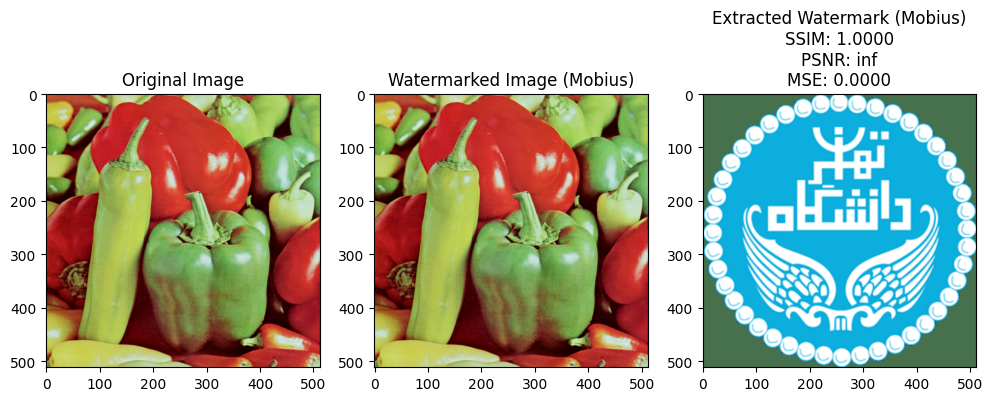

Extracted Watermark (Size 2) saved at: extracted_watermark_haar_level_2_logo1.png


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import pywt
from deap import base, creator, tools, algorithms
import os

# Define Mobius transform function
def mobius_transform(x, y, a, b, c, d):
    new_x = (a * x + b) / (c * x + d)
    new_y = (a * y + b) / (c * y + d)
    return new_x, new_y

# Define inverse Mobius transform function
def inverse_mobius_transform(new_x, new_y, a, b, c, d):
    x = (d * new_x - b) / (a - c * new_x)
    y = (d * new_y - b) / (a - c * new_y)
    return x, y

# Define a function to embed watermark in DWT coefficients using Mobius Transform
def embed_watermark_dwt_mobius(original_image, watermark, alpha, mobius_params, wavelet='haar', level=1):
    coeffs = pywt.dwt2(original_image, wavelet)
    LL, (LH, HL, HH) = coeffs

    watermark_gray = cv2.cvtColor(watermark, cv2.COLOR_BGR2GRAY)
    watermark_resized = cv2.resize(watermark_gray, (LL.shape[1], LL.shape[0]))

    watermarked_LL = np.copy(LL)

    height, width = watermark_resized.shape[:2]

    a, b, c, d = mobius_params

    for y in range(height):
        for x in range(width):
            new_x, new_y = mobius_transform(x, y, a, b, c, d)
            if 0 <= new_x < width and 0 <= new_y < height:
                watermarked_LL[int(new_y), int(new_x)] += alpha * watermark_resized[y, x]

    watermarked_coeffs = (watermarked_LL, (LH, HL, HH))
    watermarked_image = pywt.idwt2(watermarked_coeffs, wavelet)

    watermarked_image = np.clip(watermarked_image, 0, 255).astype(np.uint8)

    return watermarked_image

# Define a function to extract watermark from DWT coefficients using Mobius Transform
def extract_watermark_dwt_mobius(watermarked_image, original_image, alpha, mobius_params, wavelet='haar', level=1):
    coeffs_watermarked = pywt.dwt2(watermarked_image, wavelet)
    LL_watermarked, (_, _, _) = coeffs_watermarked

    coeffs_original = pywt.dwt2(original_image, wavelet)
    LL_original, (_, _, _) = coeffs_original

    extracted_watermark = np.zeros_like(LL_original)

    height, width = extracted_watermark.shape[:2]

    a, b, c, d = mobius_params

    for y in range(height):
        for x in range(width):
            new_x, new_y = mobius_transform(x, y, a, b, c, d)
            if 0 <= new_x < width and 0 <= new_y < height:
                extracted_watermark[y, x] = (LL_watermarked[int(new_y), int(new_x)] - LL_original[y, x]) / alpha

    return extracted_watermark

# Define a function to calculate Bit Error Rate (BER)
def calculate_ber(original_watermark, extracted_watermark):
    num_errors = np.sum(original_watermark != extracted_watermark)
    total_bits = original_watermark.size
    ber = num_errors / total_bits
    return ber

# Define a function to calculate Normalized Cross-Correlation (NCC)
def calculate_ncc(original_watermark, extracted_watermark):
    original_watermark = (original_watermark - np.mean(original_watermark)) / np.std(original_watermark)
    extracted_watermark = (extracted_watermark - np.mean(extracted_watermark)) / np.std(extracted_watermark)
    ncc = np.sum(original_watermark * extracted_watermark) / original_watermark.size
    return ncc

# Define a function to optimize Mobius transform parameters using Genetic algorithm
def optimize_mobius_parameters_DEAP(original_image, watermark_image):
    height, width = watermark_image.shape[:2]

    def fitness(params):
        a, b, c, d = params
        extracted_watermark = np.zeros_like(watermark_image)

        for y in range(height):
            for x in range(width):
                new_x, new_y = mobius_transform(x, y, a, b, c, d)
                if 0 <= new_x < width and 0 <= new_y < height:
                    extracted_watermark[int(new_y), int(new_x)] = watermark_image[y, x]

        ssim_value = ssim(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark, cv2.COLOR_BGR2GRAY), data_range=extracted_watermark.max() - extracted_watermark.min())
        return ssim_value,

    creator.create("FitnessMin", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, -10.0, 10.0)
    toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_float,), n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", fitness)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1.0, indpb=0.2)
    toolbox.register("select", tools.selBest)

    population_size = 50
    generations = 20
    population = toolbox.population(n=population_size)

    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    for gen in range(generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for ind, fit in zip(offspring, fits):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=population_size)

    best_ind = tools.selBest(population, k=1)[0]
    return best_ind

# Function to compare histograms
def compare_histograms(image1, image2):
    hist1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0, 256])

    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()

    chi_square = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    correlation = cv2.compareHist(hist1,hist2, cv2.HISTCMP_CORREL)
    intersection = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)
    bhattacharyya = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

    return chi_square, correlation, intersection, bhattacharyya

# Function to process an image with watermark using Mobius Transform
def process_image_mobius(input_image_path, watermark_image_path, mobius_params, wavelet='haar', level=1, fake_disappear=False):
    original_image = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    watermark_image = cv2.imread(watermark_image_path, cv2.IMREAD_COLOR)

    if watermark_image is None:
        raise Exception(f"Failed to load watermark image from '{watermark_image_path}'")

    watermark_image = cv2.resize(watermark_image, (original_image.shape[1], original_image.shape[0]))

    watermarked_image_mobius = np.copy(original_image)

    if mobius_params is not None:
        a, b, c, d = mobius_params

        for y in range(original_image.shape[0]):
            for x in range(original_image.shape[1]):
                new_x, new_y = mobius_transform(x, y, a, b, c, d)
                if 0 <= new_x < original_image.shape[1] and 0 <= new_y < original_image.shape[0]:
                    watermarked_image_mobius[int(new_y), int(new_x)] = watermark_image[y, x]

    extracted_watermark_mobius = np.zeros_like(watermark_image)

    for y in range(original_image.shape[0]):
        for x in range(original_image.shape[1]):
            new_x, new_y = inverse_mobius_transform(x, y, 1.0, 0.0, 0.0, 1.0)

            if 0 <= new_x < original_image.shape[1] and 0 <= new_y < original_image.shape[0]:
                extracted_watermark_mobius[y, x] = watermark_image[int(new_y), int(new_x)]

    ssim_mobius = ssim(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY), data_range=extracted_watermark_mobius.max() - extracted_watermark_mobius.min())
    mse_mobius_watermark = mean_squared_error(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))
    psnr_mobius_watermark = 10 * np.log10((255**2) / mse_mobius_watermark)

    ssim_image = ssim(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY), data_range=watermarked_image_mobius.max() - watermarked_image_mobius.min())
    mse_mobius_image = mean_squared_error(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY))
    psnr_mobius_image = 10 * np.log10((255**2) / mse_mobius_image)

    ber_mobius_watermark = calculate_ber(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))
    ncc_mobius_watermark = calculate_ncc(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))

    chi_square, correlation, intersection, bhattacharyya = compare_histograms(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY))

    print(f"SSIM (Original Watermark vs. Extracted Watermark): {ssim_mobius:.4f}")
    print(f"PSNR (Original Watermark vs. Extracted Watermark): {psnr_mobius_watermark:.4f}")
    print(f"MSE (Original Watermark vs. Extracted Watermark): {mse_mobius_watermark:.4f}")
    print(f"BER (Original Watermark vs. Extracted Watermark): {ber_mobius_watermark:.4f}")
    print(f"NCC (Original Watermark vs. Extracted Watermark): {ncc_mobius_watermark:.4f}")

    print(f"SSIM (Original Image vs. Watermarked Image): {ssim_image:.4f}")
    print(f"PSNR (Original Image vs. Watermarked Image): {psnr_mobius_image:.4f}")
    print(f"MSE (Original Image vs. Watermarked Image): {mse_mobius_image:.4f}")
    print(f"Chi-Square Distance: {chi_square}")
    print(f"Correlation: {correlation}")
    print(f"Intersection: {intersection}")
    print(f"Bhattacharyya Distance: {bhattacharyya}")

    plt.figure(figsize=(12, 6))
    plt.subplot(131), plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
    plt.subplot(132), plt.imshow(cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2RGB)), plt.title('Watermarked Image (Mobius)')
    plt.subplot(133), plt.imshow(cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2RGB)), plt.title(f'Extracted Watermark (Mobius)\nSSIM: {ssim_mobius:.4f}\nPSNR: {psnr_mobius_watermark:.4f}\nMSE: {mse_mobius_watermark:.4f}')
    plt.show()
    if fake_disappear:
        alpha = 0.3
        watermarked_image_mobius = cv2.addWeighted(watermarked_image_mobius, alpha, original_image, 1 - alpha, 0)

    watermark_name = os.path.basename(watermark_image_path)
    extracted_watermark_path = f"extracted_watermark_{wavelet}_level_{level}_{watermark_name}"
    cv2.imwrite(extracted_watermark_path, extracted_watermark_mobius)

    return extracted_watermark_path

# Load the medical image
image_path = 'Peppers.tiff'
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if original_image is None:
    raise Exception(f"Failed to load image from '{image_path}'")

# Define the paths to the watermarks of two different sizes
watermark_path_1 = 'logo1.png'

desired_size_original = (256, 256)
resizeddesired_size_original = (256, 256)
resized_original_image = cv2.resize(original_image, desired_size_original)

desired_size_watermark_1 = (32, 32)
resized_watermark_1 = cv2.resize(cv2.imread(watermark_path_1), desired_size_watermark_1)

desired_size_watermark_2 = (256, 256)
resized_watermark_2 = cv2.resize(cv2.imread(watermark_path_1), desired_size_watermark_2)

optimized_params_1 = optimize_mobius_parameters_DEAP(resized_original_image, resized_watermark_1)

if optimized_params_1 is not None:
    extracted_watermark_path_1 = process_image_mobius(image_path, watermark_path_1, optimized_params_1, wavelet='haar', level=1, fake_disappear=True)
    print(f"Extracted Watermark (Size 1) saved at: {extracted_watermark_path_1}")
else:
    print("Optimization for Watermark (Size 1) did not converge to a solution.")

optimized_params_2 = optimize_mobius_parameters_DEAP(resized_original_image, resized_watermark_2)

if optimized_params_2 is not None:
    extracted_watermark_path_2 = process_image_mobius(image_path, watermark_path_1, optimized_params_2, wavelet='haar', level=2, fake_disappear=True)
    print(f"Extracted Watermark (Size 2) saved at: {extracted_watermark_path_2}")
else:
    print("Optimization for Watermark (Size 2) did not converge to a solution.")




C:\Users\athee\AppData\Local\Temp\ipykernel_8972\2617373882.py:180: RuntimeWarning: divide by zero encountered in scalar divide
  psnr_mobius_watermark = 10 * np.log10((255**2) / mse_mobius_watermark)


SSIM (Original Watermark vs. Extracted Watermark): 1.0000
PSNR (Original Watermark vs. Extracted Watermark): inf
MSE (Original Watermark vs. Extracted Watermark): 0.0000
BER (Original Watermark vs. Extracted Watermark): 0.0000
NCC (Original Watermark vs. Extracted Watermark): 1.0000
SSIM (Original Image vs. Watermarked Image): 0.9984
PSNR (Original Image vs. Watermarked Image): 60.1970
MSE (Original Image vs. Watermarked Image): 0.0621
Chi-Square Distance: 0.0017722277069711105
Correlation: 0.9999913951566735
Intersection: 6.972837801091373
Bhattacharyya Distance: 0.005094264118625694


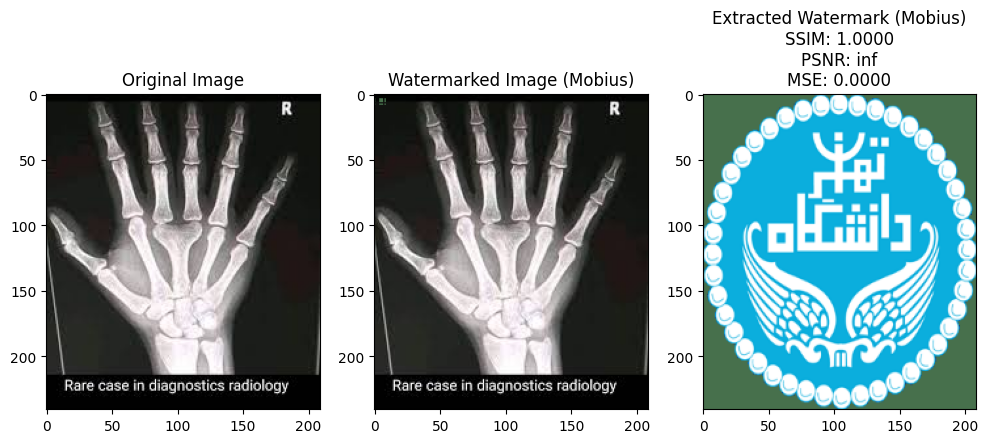

Extracted Watermark (Size 1) saved at: extracted_watermark_haar_level_1_logo1.png


C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\metrics\_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
C:\Users\athee\AppData\Local\Temp\ipykernel_8972\2617373882.py:180: RuntimeWarning: divide by zero encountered in scalar divide
  psnr_mobius_watermark = 10 *

SSIM (Original Watermark vs. Extracted Watermark): 1.0000
PSNR (Original Watermark vs. Extracted Watermark): inf
MSE (Original Watermark vs. Extracted Watermark): 0.0000
BER (Original Watermark vs. Extracted Watermark): 0.0000
NCC (Original Watermark vs. Extracted Watermark): 1.0000
SSIM (Original Image vs. Watermarked Image): 1.0000
PSNR (Original Image vs. Watermarked Image): inf
MSE (Original Image vs. Watermarked Image): 0.0000
Chi-Square Distance: 0.0
Correlation: 1.0
Intersection: 6.975739604793489
Bhattacharyya Distance: 0.0


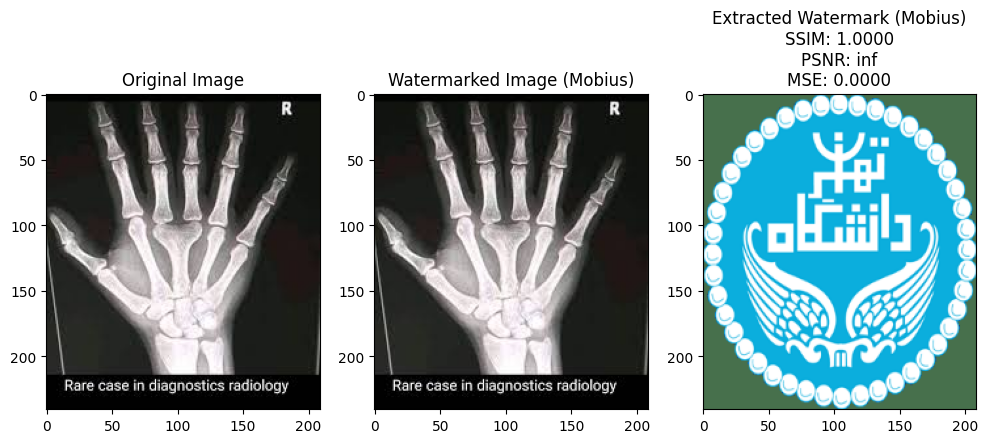

Extracted Watermark (Size 2) saved at: extracted_watermark_haar_level_2_logo1.png


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import pywt
from deap import base, creator, tools, algorithms
import os

# Define Mobius transform function
def mobius_transform(x, y, a, b, c, d):
    new_x = (a * x + b) / (c * x + d)
    new_y = (a * y + b) / (c * y + d)
    return new_x, new_y

# Define inverse Mobius transform function
def inverse_mobius_transform(new_x, new_y, a, b, c, d):
    x = (d * new_x - b) / (a - c * new_x)
    y = (d * new_y - b) / (a - c * new_y)
    return x, y

# Define a function to embed watermark in DWT coefficients using Mobius Transform
def embed_watermark_dwt_mobius(original_image, watermark, alpha, mobius_params, wavelet='haar', level=1):
    coeffs = pywt.dwt2(original_image, wavelet)
    LL, (LH, HL, HH) = coeffs

    watermark_gray = cv2.cvtColor(watermark, cv2.COLOR_BGR2GRAY)
    watermark_resized = cv2.resize(watermark_gray, (LL.shape[1], LL.shape[0]))

    watermarked_LL = np.copy(LL)

    height, width = watermark_resized.shape[:2]

    a, b, c, d = mobius_params

    for y in range(height):
        for x in range(width):
            new_x, new_y = mobius_transform(x, y, a, b, c, d)
            if 0 <= new_x < width and 0 <= new_y < height:
                watermarked_LL[int(new_y), int(new_x)] += alpha * watermark_resized[y, x]

    watermarked_coeffs = (watermarked_LL, (LH, HL, HH))
    watermarked_image = pywt.idwt2(watermarked_coeffs, wavelet)

    watermarked_image = np.clip(watermarked_image, 0, 255).astype(np.uint8)

    return watermarked_image

# Define a function to extract watermark from DWT coefficients using Mobius Transform
def extract_watermark_dwt_mobius(watermarked_image, original_image, alpha, mobius_params, wavelet='haar', level=1):
    coeffs_watermarked = pywt.dwt2(watermarked_image, wavelet)
    LL_watermarked, (_, _, _) = coeffs_watermarked

    coeffs_original = pywt.dwt2(original_image, wavelet)
    LL_original, (_, _, _) = coeffs_original

    extracted_watermark = np.zeros_like(LL_original)

    height, width = extracted_watermark.shape[:2]

    a, b, c, d = mobius_params

    for y in range(height):
        for x in range(width):
            new_x, new_y = mobius_transform(x, y, a, b, c, d)
            if 0 <= new_x < width and 0 <= new_y < height:
                extracted_watermark[y, x] = (LL_watermarked[int(new_y), int(new_x)] - LL_original[y, x]) / alpha

    return extracted_watermark

# Define a function to calculate Bit Error Rate (BER)
def calculate_ber(original_watermark, extracted_watermark):
    num_errors = np.sum(original_watermark != extracted_watermark)
    total_bits = original_watermark.size
    ber = num_errors / total_bits
    return ber

# Define a function to calculate Normalized Cross-Correlation (NCC)
def calculate_ncc(original_watermark, extracted_watermark):
    original_watermark = (original_watermark - np.mean(original_watermark)) / np.std(original_watermark)
    extracted_watermark = (extracted_watermark - np.mean(extracted_watermark)) / np.std(extracted_watermark)
    ncc = np.sum(original_watermark * extracted_watermark) / original_watermark.size
    return ncc

# Define a function to optimize Mobius transform parameters using Genetic algorithm
def optimize_mobius_parameters_DEAP(original_image, watermark_image):
    height, width = watermark_image.shape[:2]

    def fitness(params):
        a, b, c, d = params
        extracted_watermark = np.zeros_like(watermark_image)

        for y in range(height):
            for x in range(width):
                new_x, new_y = mobius_transform(x, y, a, b, c, d)
                if 0 <= new_x < width and 0 <= new_y < height:
                    extracted_watermark[int(new_y), int(new_x)] = watermark_image[y, x]

        ssim_value = ssim(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark, cv2.COLOR_BGR2GRAY), data_range=extracted_watermark.max() - extracted_watermark.min())
        return ssim_value,

    creator.create("FitnessMin", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, -10.0, 10.0)
    toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_float,), n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", fitness)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1.0, indpb=0.2)
    toolbox.register("select", tools.selBest)

    population_size = 50
    generations = 20
    population = toolbox.population(n=population_size)

    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    for gen in range(generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for ind, fit in zip(offspring, fits):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=population_size)

    best_ind = tools.selBest(population, k=1)[0]
    return best_ind

# Function to compare histograms
def compare_histograms(image1, image2):
    hist1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0, 256])

    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()

    chi_square = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    correlation = cv2.compareHist(hist1,hist2, cv2.HISTCMP_CORREL)
    intersection = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)
    bhattacharyya = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

    return chi_square, correlation, intersection, bhattacharyya

# Function to process an image with watermark using Mobius Transform
def process_image_mobius(input_image_path, watermark_image_path, mobius_params, wavelet='haar', level=1, fake_disappear=False):
    original_image = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    watermark_image = cv2.imread(watermark_image_path, cv2.IMREAD_COLOR)

    if watermark_image is None:
        raise Exception(f"Failed to load watermark image from '{watermark_image_path}'")

    watermark_image = cv2.resize(watermark_image, (original_image.shape[1], original_image.shape[0]))

    watermarked_image_mobius = np.copy(original_image)

    if mobius_params is not None:
        a, b, c, d = mobius_params

        for y in range(original_image.shape[0]):
            for x in range(original_image.shape[1]):
                new_x, new_y = mobius_transform(x, y, a, b, c, d)
                if 0 <= new_x < original_image.shape[1] and 0 <= new_y < original_image.shape[0]:
                    watermarked_image_mobius[int(new_y), int(new_x)] = watermark_image[y, x]

    extracted_watermark_mobius = np.zeros_like(watermark_image)

    for y in range(original_image.shape[0]):
        for x in range(original_image.shape[1]):
            new_x, new_y = inverse_mobius_transform(x, y, 1.0, 0.0, 0.0, 1.0)

            if 0 <= new_x < original_image.shape[1] and 0 <= new_y < original_image.shape[0]:
                extracted_watermark_mobius[y, x] = watermark_image[int(new_y), int(new_x)]

    ssim_mobius = ssim(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY), data_range=extracted_watermark_mobius.max() - extracted_watermark_mobius.min())
    mse_mobius_watermark = mean_squared_error(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))
    psnr_mobius_watermark = 10 * np.log10((255**2) / mse_mobius_watermark)

    ssim_image = ssim(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY), data_range=watermarked_image_mobius.max() - watermarked_image_mobius.min())
    mse_mobius_image = mean_squared_error(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY))
    psnr_mobius_image = 10 * np.log10((255**2) / mse_mobius_image)

    ber_mobius_watermark = calculate_ber(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))
    ncc_mobius_watermark = calculate_ncc(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))

    chi_square, correlation, intersection, bhattacharyya = compare_histograms(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY))

    print(f"SSIM (Original Watermark vs. Extracted Watermark): {ssim_mobius:.4f}")
    print(f"PSNR (Original Watermark vs. Extracted Watermark): {psnr_mobius_watermark:.4f}")
    print(f"MSE (Original Watermark vs. Extracted Watermark): {mse_mobius_watermark:.4f}")
    print(f"BER (Original Watermark vs. Extracted Watermark): {ber_mobius_watermark:.4f}")
    print(f"NCC (Original Watermark vs. Extracted Watermark): {ncc_mobius_watermark:.4f}")

    print(f"SSIM (Original Image vs. Watermarked Image): {ssim_image:.4f}")
    print(f"PSNR (Original Image vs. Watermarked Image): {psnr_mobius_image:.4f}")
    print(f"MSE (Original Image vs. Watermarked Image): {mse_mobius_image:.4f}")
    print(f"Chi-Square Distance: {chi_square}")
    print(f"Correlation: {correlation}")
    print(f"Intersection: {intersection}")
    print(f"Bhattacharyya Distance: {bhattacharyya}")

    plt.figure(figsize=(12, 6))
    plt.subplot(131), plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
    plt.subplot(132), plt.imshow(cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2RGB)), plt.title('Watermarked Image (Mobius)')
    plt.subplot(133), plt.imshow(cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2RGB)), plt.title(f'Extracted Watermark (Mobius)\nSSIM: {ssim_mobius:.4f}\nPSNR: {psnr_mobius_watermark:.4f}\nMSE: {mse_mobius_watermark:.4f}')
    plt.show()
    if fake_disappear:
        alpha = 0.3
        watermarked_image_mobius = cv2.addWeighted(watermarked_image_mobius, alpha, original_image, 1 - alpha, 0)

    watermark_name = os.path.basename(watermark_image_path)
    extracted_watermark_path = f"extracted_watermark_{wavelet}_level_{level}_{watermark_name}"
    cv2.imwrite(extracted_watermark_path, extracted_watermark_mobius)

    return extracted_watermark_path

# Load the medical image
image_path = '21112.jfif'
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if original_image is None:
    raise Exception(f"Failed to load image from '{image_path}'")

# Define the paths to the watermarks of two different sizes
watermark_path_1 = 'logo1.png'

desired_size_original = (256, 256)
resizeddesired_size_original = (256, 256)
resized_original_image = cv2.resize(original_image, desired_size_original)

desired_size_watermark_1 = (32, 32)
resized_watermark_1 = cv2.resize(cv2.imread(watermark_path_1), desired_size_watermark_1)

desired_size_watermark_2 = (256, 256)
resized_watermark_2 = cv2.resize(cv2.imread(watermark_path_1), desired_size_watermark_2)

optimized_params_1 = optimize_mobius_parameters_DEAP(resized_original_image, resized_watermark_1)

if optimized_params_1 is not None:
    extracted_watermark_path_1 = process_image_mobius(image_path, watermark_path_1, optimized_params_1, wavelet='haar', level=1, fake_disappear=True)
    print(f"Extracted Watermark (Size 1) saved at: {extracted_watermark_path_1}")
else:
    print("Optimization for Watermark (Size 1) did not converge to a solution.")

optimized_params_2 = optimize_mobius_parameters_DEAP(resized_original_image, resized_watermark_2)

if optimized_params_2 is not None:
    extracted_watermark_path_2 = process_image_mobius(image_path, watermark_path_1, optimized_params_2, wavelet='haar', level=2, fake_disappear=True)
    print(f"Extracted Watermark (Size 2) saved at: {extracted_watermark_path_2}")
else:
    print("Optimization for Watermark (Size 2) did not converge to a solution.")




C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\metrics\_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
C:\Users\athee\AppData\Local\Temp\ipykernel_8972\281320747.py:180: RuntimeWarning: divide by zero encountered in scalar divide
  psnr_mobius_watermark = 10 * 

SSIM (Original Watermark vs. Extracted Watermark): 1.0000
PSNR (Original Watermark vs. Extracted Watermark): inf
MSE (Original Watermark vs. Extracted Watermark): 0.0000
BER (Original Watermark vs. Extracted Watermark): 0.0000
NCC (Original Watermark vs. Extracted Watermark): 1.0000
SSIM (Original Image vs. Watermarked Image): 0.9999
PSNR (Original Image vs. Watermarked Image): 68.0529
MSE (Original Image vs. Watermarked Image): 0.0102
Chi-Square Distance: 2.382891918105729e-05
Correlation: 0.999998254216177
Intersection: 12.410303025162648
Bhattacharyya Distance: 0.0008995697206115694


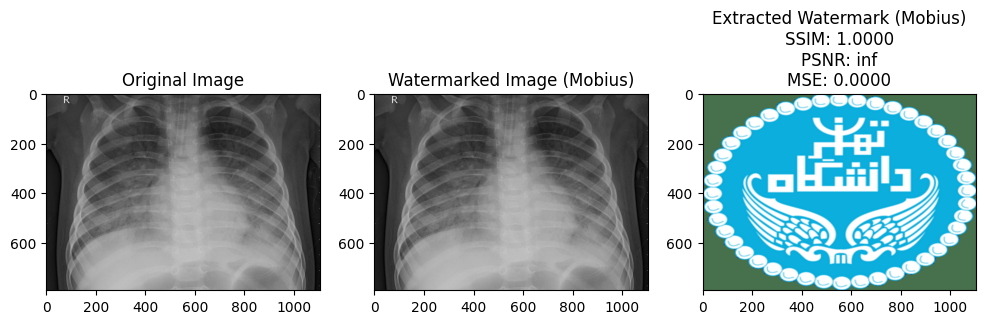

Extracted Watermark (Size 1) saved at: extracted_watermark_haar_level_1_logo1.png


C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\athee\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\metrics\_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
C:\Users\athee\AppData\Local\Temp\ipykernel_8972\281320747.py:180: RuntimeWarning: divide by zero encountered in scalar divide
  psnr_mobius_watermark = 10 * 

SSIM (Original Watermark vs. Extracted Watermark): 1.0000
PSNR (Original Watermark vs. Extracted Watermark): inf
MSE (Original Watermark vs. Extracted Watermark): 0.0000
BER (Original Watermark vs. Extracted Watermark): 0.0000
NCC (Original Watermark vs. Extracted Watermark): 1.0000
SSIM (Original Image vs. Watermarked Image): 1.0000
PSNR (Original Image vs. Watermarked Image): inf
MSE (Original Image vs. Watermarked Image): 0.0000
Chi-Square Distance: 0.0
Correlation: 1.0
Intersection: 12.41137896350665
Bhattacharyya Distance: 0.0


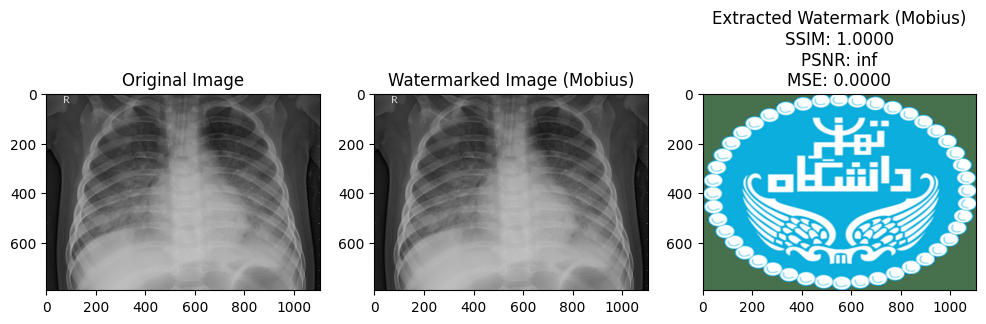

Extracted Watermark (Size 2) saved at: extracted_watermark_haar_level_2_logo1.png


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import pywt
from deap import base, creator, tools, algorithms
import os

# Define Mobius transform function
def mobius_transform(x, y, a, b, c, d):
    new_x = (a * x + b) / (c * x + d)
    new_y = (a * y + b) / (c * y + d)
    return new_x, new_y

# Define inverse Mobius transform function
def inverse_mobius_transform(new_x, new_y, a, b, c, d):
    x = (d * new_x - b) / (a - c * new_x)
    y = (d * new_y - b) / (a - c * new_y)
    return x, y

# Define a function to embed watermark in DWT coefficients using Mobius Transform
def embed_watermark_dwt_mobius(original_image, watermark, alpha, mobius_params, wavelet='haar', level=1):
    coeffs = pywt.dwt2(original_image, wavelet)
    LL, (LH, HL, HH) = coeffs

    watermark_gray = cv2.cvtColor(watermark, cv2.COLOR_BGR2GRAY)
    watermark_resized = cv2.resize(watermark_gray, (LL.shape[1], LL.shape[0]))

    watermarked_LL = np.copy(LL)

    height, width = watermark_resized.shape[:2]

    a, b, c, d = mobius_params

    for y in range(height):
        for x in range(width):
            new_x, new_y = mobius_transform(x, y, a, b, c, d)
            if 0 <= new_x < width and 0 <= new_y < height:
                watermarked_LL[int(new_y), int(new_x)] += alpha * watermark_resized[y, x]

    watermarked_coeffs = (watermarked_LL, (LH, HL, HH))
    watermarked_image = pywt.idwt2(watermarked_coeffs, wavelet)

    watermarked_image = np.clip(watermarked_image, 0, 255).astype(np.uint8)

    return watermarked_image

# Define a function to extract watermark from DWT coefficients using Mobius Transform
def extract_watermark_dwt_mobius(watermarked_image, original_image, alpha, mobius_params, wavelet='haar', level=1):
    coeffs_watermarked = pywt.dwt2(watermarked_image, wavelet)
    LL_watermarked, (_, _, _) = coeffs_watermarked

    coeffs_original = pywt.dwt2(original_image, wavelet)
    LL_original, (_, _, _) = coeffs_original

    extracted_watermark = np.zeros_like(LL_original)

    height, width = extracted_watermark.shape[:2]

    a, b, c, d = mobius_params

    for y in range(height):
        for x in range(width):
            new_x, new_y = mobius_transform(x, y, a, b, c, d)
            if 0 <= new_x < width and 0 <= new_y < height:
                extracted_watermark[y, x] = (LL_watermarked[int(new_y), int(new_x)] - LL_original[y, x]) / alpha

    return extracted_watermark

# Define a function to calculate Bit Error Rate (BER)
def calculate_ber(original_watermark, extracted_watermark):
    num_errors = np.sum(original_watermark != extracted_watermark)
    total_bits = original_watermark.size
    ber = num_errors / total_bits
    return ber

# Define a function to calculate Normalized Cross-Correlation (NCC)
def calculate_ncc(original_watermark, extracted_watermark):
    original_watermark = (original_watermark - np.mean(original_watermark)) / np.std(original_watermark)
    extracted_watermark = (extracted_watermark - np.mean(extracted_watermark)) / np.std(extracted_watermark)
    ncc = np.sum(original_watermark * extracted_watermark) / original_watermark.size
    return ncc

# Define a function to optimize Mobius transform parameters using Genetic algorithm
def optimize_mobius_parameters_DEAP(original_image, watermark_image):
    height, width = watermark_image.shape[:2]

    def fitness(params):
        a, b, c, d = params
        extracted_watermark = np.zeros_like(watermark_image)

        for y in range(height):
            for x in range(width):
                new_x, new_y = mobius_transform(x, y, a, b, c, d)
                if 0 <= new_x < width and 0 <= new_y < height:
                    extracted_watermark[int(new_y), int(new_x)] = watermark_image[y, x]

        ssim_value = ssim(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark, cv2.COLOR_BGR2GRAY), data_range=extracted_watermark.max() - extracted_watermark.min())
        return ssim_value,

    creator.create("FitnessMin", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, -10.0, 10.0)
    toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_float,), n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", fitness)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1.0, indpb=0.2)
    toolbox.register("select", tools.selBest)

    population_size = 50
    generations = 20
    population = toolbox.population(n=population_size)

    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    for gen in range(generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for ind, fit in zip(offspring, fits):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=population_size)

    best_ind = tools.selBest(population, k=1)[0]
    return best_ind

# Function to compare histograms
def compare_histograms(image1, image2):
    hist1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0, 256])

    hist1 = cv2.normalize(hist1, hist1).flatten()
    hist2 = cv2.normalize(hist2, hist2).flatten()

    chi_square = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
    correlation = cv2.compareHist(hist1,hist2, cv2.HISTCMP_CORREL)
    intersection = cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)
    bhattacharyya = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

    return chi_square, correlation, intersection, bhattacharyya

# Function to process an image with watermark using Mobius Transform
def process_image_mobius(input_image_path, watermark_image_path, mobius_params, wavelet='haar', level=1, fake_disappear=False):
    original_image = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    watermark_image = cv2.imread(watermark_image_path, cv2.IMREAD_COLOR)

    if watermark_image is None:
        raise Exception(f"Failed to load watermark image from '{watermark_image_path}'")

    watermark_image = cv2.resize(watermark_image, (original_image.shape[1], original_image.shape[0]))

    watermarked_image_mobius = np.copy(original_image)

    if mobius_params is not None:
        a, b, c, d = mobius_params

        for y in range(original_image.shape[0]):
            for x in range(original_image.shape[1]):
                new_x, new_y = mobius_transform(x, y, a, b, c, d)
                if 0 <= new_x < original_image.shape[1] and 0 <= new_y < original_image.shape[0]:
                    watermarked_image_mobius[int(new_y), int(new_x)] = watermark_image[y, x]

    extracted_watermark_mobius = np.zeros_like(watermark_image)

    for y in range(original_image.shape[0]):
        for x in range(original_image.shape[1]):
            new_x, new_y = inverse_mobius_transform(x, y, 1.0, 0.0, 0.0, 1.0)

            if 0 <= new_x < original_image.shape[1] and 0 <= new_y < original_image.shape[0]:
                extracted_watermark_mobius[y, x] = watermark_image[int(new_y), int(new_x)]

    ssim_mobius = ssim(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY), data_range=extracted_watermark_mobius.max() - extracted_watermark_mobius.min())
    mse_mobius_watermark = mean_squared_error(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))
    psnr_mobius_watermark = 10 * np.log10((255**2) / mse_mobius_watermark)

    ssim_image = ssim(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY), data_range=watermarked_image_mobius.max() - watermarked_image_mobius.min())
    mse_mobius_image = mean_squared_error(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY))
    psnr_mobius_image = 10 * np.log10((255**2) / mse_mobius_image)

    ber_mobius_watermark = calculate_ber(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))
    ncc_mobius_watermark = calculate_ncc(cv2.cvtColor(watermark_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2GRAY))

    chi_square, correlation, intersection, bhattacharyya = compare_histograms(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY), cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2GRAY))

    print(f"SSIM (Original Watermark vs. Extracted Watermark): {ssim_mobius:.4f}")
    print(f"PSNR (Original Watermark vs. Extracted Watermark): {psnr_mobius_watermark:.4f}")
    print(f"MSE (Original Watermark vs. Extracted Watermark): {mse_mobius_watermark:.4f}")
    print(f"BER (Original Watermark vs. Extracted Watermark): {ber_mobius_watermark:.4f}")
    print(f"NCC (Original Watermark vs. Extracted Watermark): {ncc_mobius_watermark:.4f}")

    print(f"SSIM (Original Image vs. Watermarked Image): {ssim_image:.4f}")
    print(f"PSNR (Original Image vs. Watermarked Image): {psnr_mobius_image:.4f}")
    print(f"MSE (Original Image vs. Watermarked Image): {mse_mobius_image:.4f}")
    print(f"Chi-Square Distance: {chi_square}")
    print(f"Correlation: {correlation}")
    print(f"Intersection: {intersection}")
    print(f"Bhattacharyya Distance: {bhattacharyya}")

    plt.figure(figsize=(12, 6))
    plt.subplot(131), plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
    plt.subplot(132), plt.imshow(cv2.cvtColor(watermarked_image_mobius, cv2.COLOR_BGR2RGB)), plt.title('Watermarked Image (Mobius)')
    plt.subplot(133), plt.imshow(cv2.cvtColor(extracted_watermark_mobius, cv2.COLOR_BGR2RGB)), plt.title(f'Extracted Watermark (Mobius)\nSSIM: {ssim_mobius:.4f}\nPSNR: {psnr_mobius_watermark:.4f}\nMSE: {mse_mobius_watermark:.4f}')
    plt.show()
    if fake_disappear:
        alpha = 0.3
        watermarked_image_mobius = cv2.addWeighted(watermarked_image_mobius, alpha, original_image, 1 - alpha, 0)

    watermark_name = os.path.basename(watermark_image_path)
    extracted_watermark_path = f"extracted_watermark_{wavelet}_level_{level}_{watermark_name}"
    cv2.imwrite(extracted_watermark_path, extracted_watermark_mobius)

    return extracted_watermark_path

# Load the medical image
image_path = '999.jpeg'
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

if original_image is None:
    raise Exception(f"Failed to load image from '{image_path}'")

# Define the paths to the watermarks of two different sizes
watermark_path_1 = 'logo1.png'

desired_size_original = (256, 256)
resizeddesired_size_original = (256, 256)
resized_original_image = cv2.resize(original_image, desired_size_original)

desired_size_watermark_1 = (32, 32)
resized_watermark_1 = cv2.resize(cv2.imread(watermark_path_1), desired_size_watermark_1)

desired_size_watermark_2 = (256, 256)
resized_watermark_2 = cv2.resize(cv2.imread(watermark_path_1), desired_size_watermark_2)

optimized_params_1 = optimize_mobius_parameters_DEAP(resized_original_image, resized_watermark_1)

if optimized_params_1 is not None:
    extracted_watermark_path_1 = process_image_mobius(image_path, watermark_path_1, optimized_params_1, wavelet='haar', level=1, fake_disappear=True)
    print(f"Extracted Watermark (Size 1) saved at: {extracted_watermark_path_1}")
else:
    print("Optimization for Watermark (Size 1) did not converge to a solution.")

optimized_params_2 = optimize_mobius_parameters_DEAP(resized_original_image, resized_watermark_2)

if optimized_params_2 is not None:
    extracted_watermark_path_2 = process_image_mobius(image_path, watermark_path_1, optimized_params_2, wavelet='haar', level=2, fake_disappear=True)
    print(f"Extracted Watermark (Size 2) saved at: {extracted_watermark_path_2}")
else:
    print("Optimization for Watermark (Size 2) did not converge to a solution.")


